In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import seaborn as sns


%matplotlib inline

import matplotlib
%config InlineBackend.figure_format='retina'

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster

# turn off warnings
import warnings
warnings.filterwarnings('ignore')
# turn off future warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import pyalex
from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders

from collections import Counter

from sklearn.mixture import GaussianMixture

import requests
import urllib


In [2]:
countries = ['Denmark', 'Finland', 'Poland',
       'Greece', 'France', 'Romania', 'Germany', 'Italy', 'Czech Republic', 'Hungary', 'Spain', 'Sweden',
       'Slovakia', 'Netherlands', 'Ireland',
       'Cyprus', 'Belgium', 'Austria', 'Lithuania', 'Estonia', 'Portugal', 'Slovenia', 'Luxembourg', 'Croatia']

country_codes = ['DK', 'FI', 'PL', 'GR', 'FR', 'RO', 'DE', 'IT', 'CZ', 'HU', 'ES', 'SE', 'SK', 'NL', 'IE', 'CY', 'BE', 'AT', 'LT', 'EE', 'PT', 'SI', 'LU', 'HR']

In [3]:
# import pkl file with data
with open('./2019_data.pkl', 'rb') as f:
    data2019 = pd.read_pickle(f)

with open('./2020_data.pkl', 'rb') as f:
    data2020 = pd.read_pickle(f)

with open('./2021_data.pkl', 'rb') as f:
    data2021 = pd.read_pickle(f)

with open('./2022_data.pkl', 'rb') as f:
    data2022 = pd.read_pickle(f)

with open('./2023_data.pkl', 'rb') as f:
    data2023 = pd.read_pickle(f)

# combine all data
data = pd.concat([data2019, data2020, data2021, data2022, data2023])

In [4]:
data

,uni,ror id,country,year,n_papers_all,paper_type,n_paper_type,n_publishers,n_mdpi,n_taylor_francis,n_springer_nature,n_wiley,n_sage,n_elsevier,n_is_retracted,n_is_oa,n_is_oa_gold
0,Aalborg University,04m5j1k67,Denmark,2019,4423,journal-article,3114,193,208,162,39,191,81,697,2,2045,805
1,Aalto University,020hwjq30,Finland,2019,3650,journal-article,2565,160,156,68,52,159,48,578,0,1989,539
2,Aarhus University,01aj84f44,Denmark,2019,7497,journal-article,6126,277,167,250,223,678,139,1311,2,3866,1372
3,"Academic Center for Education, Culture and Res...",0126z4b94,Iran,2019,835,journal-article,794,94,2,20,28,70,10,153,2,282,185
4,Academy of Scientific and Innovative Research,053rcsq61,India,2019,2036,journal-article,1854,75,17,70,36,244,8,641,3,411,230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406,Çukurova University,05wxkj555,Turkey,2023,2089,journal-article,1889,191,78,60,15,71,20,223,1,1362,579
1407,Örebro University,05kytsw45,Sweden,2023,1387,journal-article,1164,116,51,95,40,96,53,260,0,988,402
1408,İnönü University,04asck240,Turkey,2023,1527,journal-article,1380,158,47,44,14,50,17,161,0,1001,437
1409,İstanbul University Cerrahpaşa,01dzn5f42,Turkey,2023,2414,journal-article,2106,184,87,72,38,136,37,373,0,1296,593


In [5]:
# find rows where sum of 'n_taylor_francis', 'n_springer_nature', 'n_wiley', 'n_elsevier', 'n_sage' is zero
# these rows are not useful for analysis
data['sum'] = data['n_taylor_francis'] + data['n_springer_nature'] + data['n_wiley'] + data['n_elsevier'] + data['n_sage']
data[data['sum'] == 0]
# drop these rows
data = data[data['sum'] != 0]


In [6]:
# add mdpi ratio column 'f_mdpi_2019' as a ratio of 'n_mdpi' to sum of 'n_taylor_francis', 'n_springer_nature', 'n_wiley', 'n_elsevier', 'n_sage'
data['f_mdpi'] = data['n_mdpi'] / (data['sum']+data['n_mdpi'])



<Axes: xlabel='f_mdpi', ylabel='Density'>

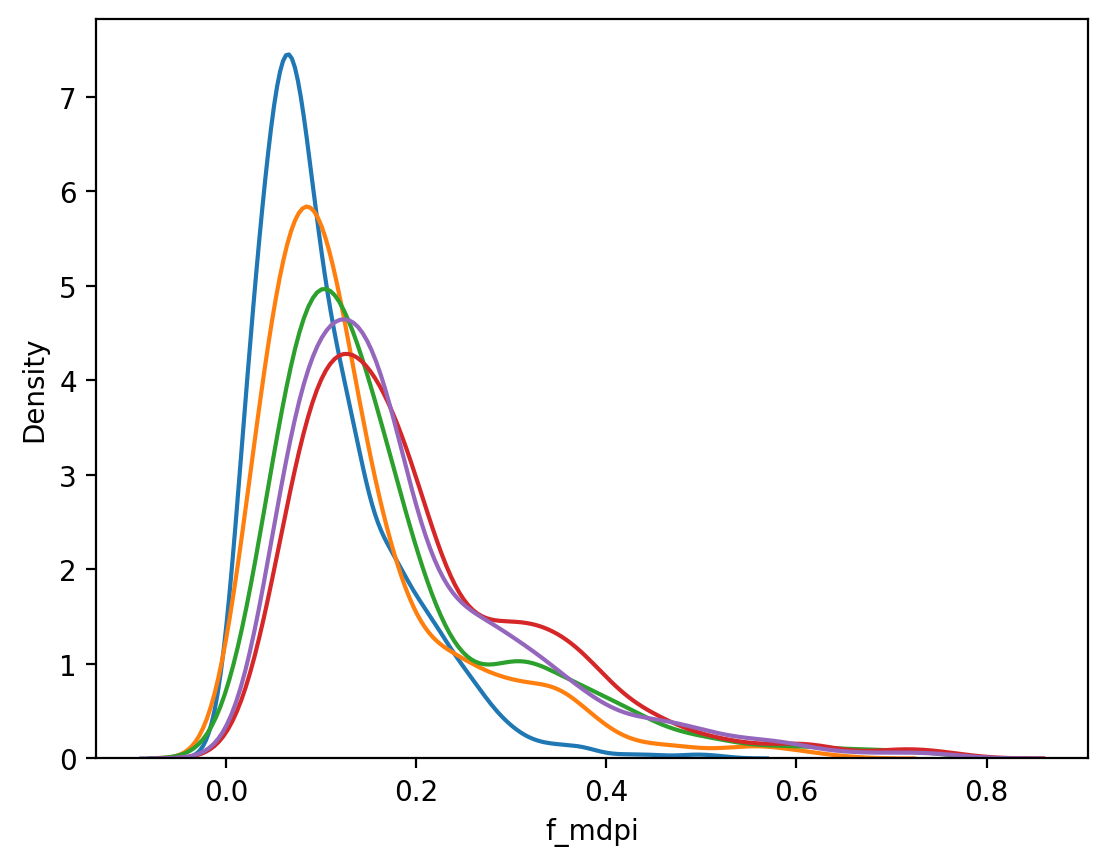

In [7]:
data2019 = data[data['year'] == '2019']
data2020 = data[data['year'] == '2020']
data2021 = data[data['year'] == '2021']
data2022 = data[data['year'] == '2022']
data2023 = data[data['year'] == '2023']
# plot kde of histograms of mdpi ratios
sns.kdeplot(data2019['f_mdpi'], label='2019')
sns.kdeplot(data2020['f_mdpi'], label='2020')
sns.kdeplot(data2021['f_mdpi'], label='2021')
sns.kdeplot(data2022['f_mdpi'], label='2022')
sns.kdeplot(data2023['f_mdpi'], label='2023')

<ErrorbarContainer object of 3 artists>

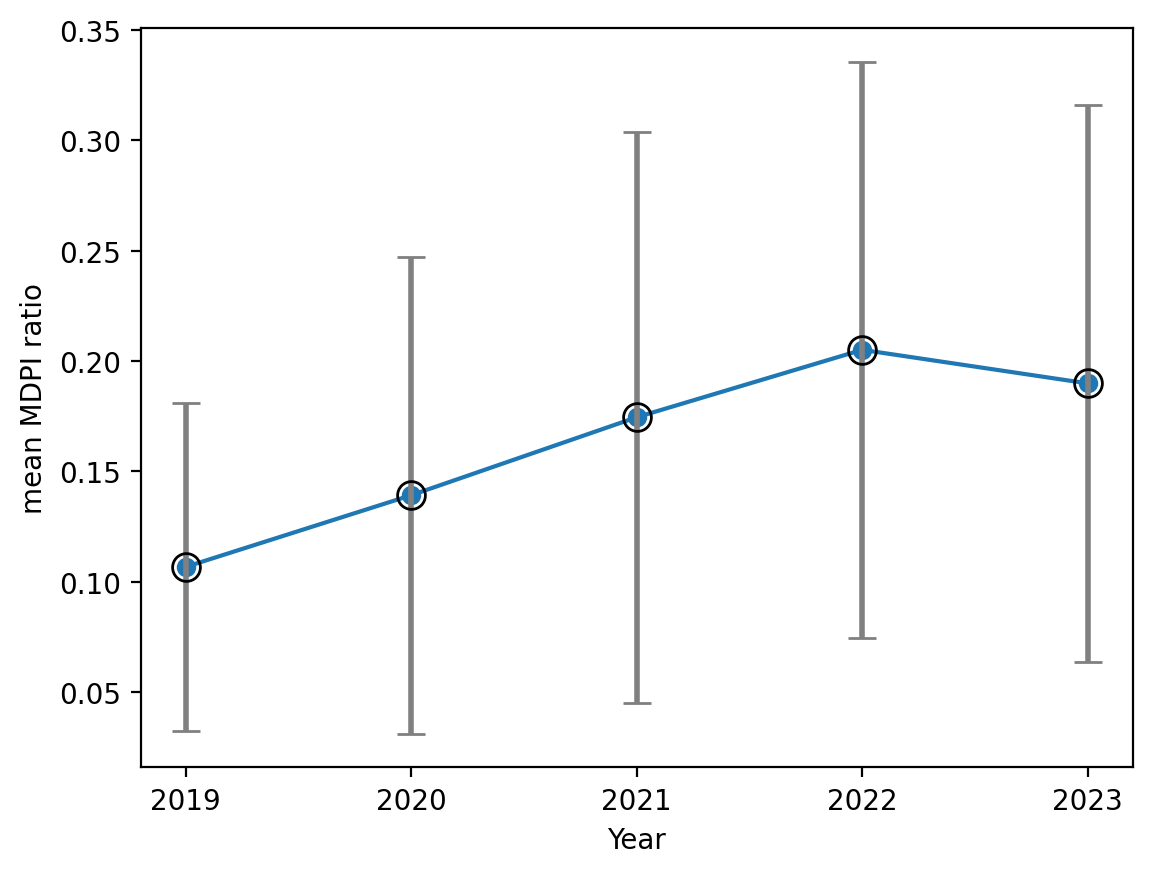

In [8]:
# plot means of mdpi ratios vs years
plt.plot(data.groupby('year')['f_mdpi'].mean(), 'o-',)
plt.xlabel('Year')
plt.ylabel('mean MDPI ratio')
# add error bars
plt.errorbar(data.groupby('year')['f_mdpi'].mean().index, data.groupby('year')['f_mdpi'].mean(), yerr=data.groupby('year')['f_mdpi'].std(), color='black', 
ecolor='gray', elinewidth=2, capsize=5,mfc='none', ms=10, fmt='o')


In [9]:
# # plot means of mdpi ratios vs years for countries
country_mean = data.groupby(['year', 'country'])['f_mdpi'].mean().unstack()
country_std = data.groupby(['year', 'country'])['f_mdpi'].std().unstack()

In [10]:
country_mean[['Croatia','Slovenia','Netherlands','United States','United Kingdom','China']]

country,Croatia,Slovenia,Netherlands,United States,United Kingdom,China
year,,,,,,
2019,0.193891,0.223427,0.075051,0.056150,0.065253,0.116900
2020,0.323064,0.348427,0.099205,0.072441,0.088618,0.097209
2021,0.480495,0.461240,0.122542,0.091281,0.113183,0.115591
2022,0.526795,0.485407,0.112858,0.103982,0.122164,0.199138
2023,0.550481,0.450051,0.094839,0.103434,0.112273,0.177740


<Axes: title={'center': '2023'}, xlabel='Country', ylabel='Mean MDPI ratio'>

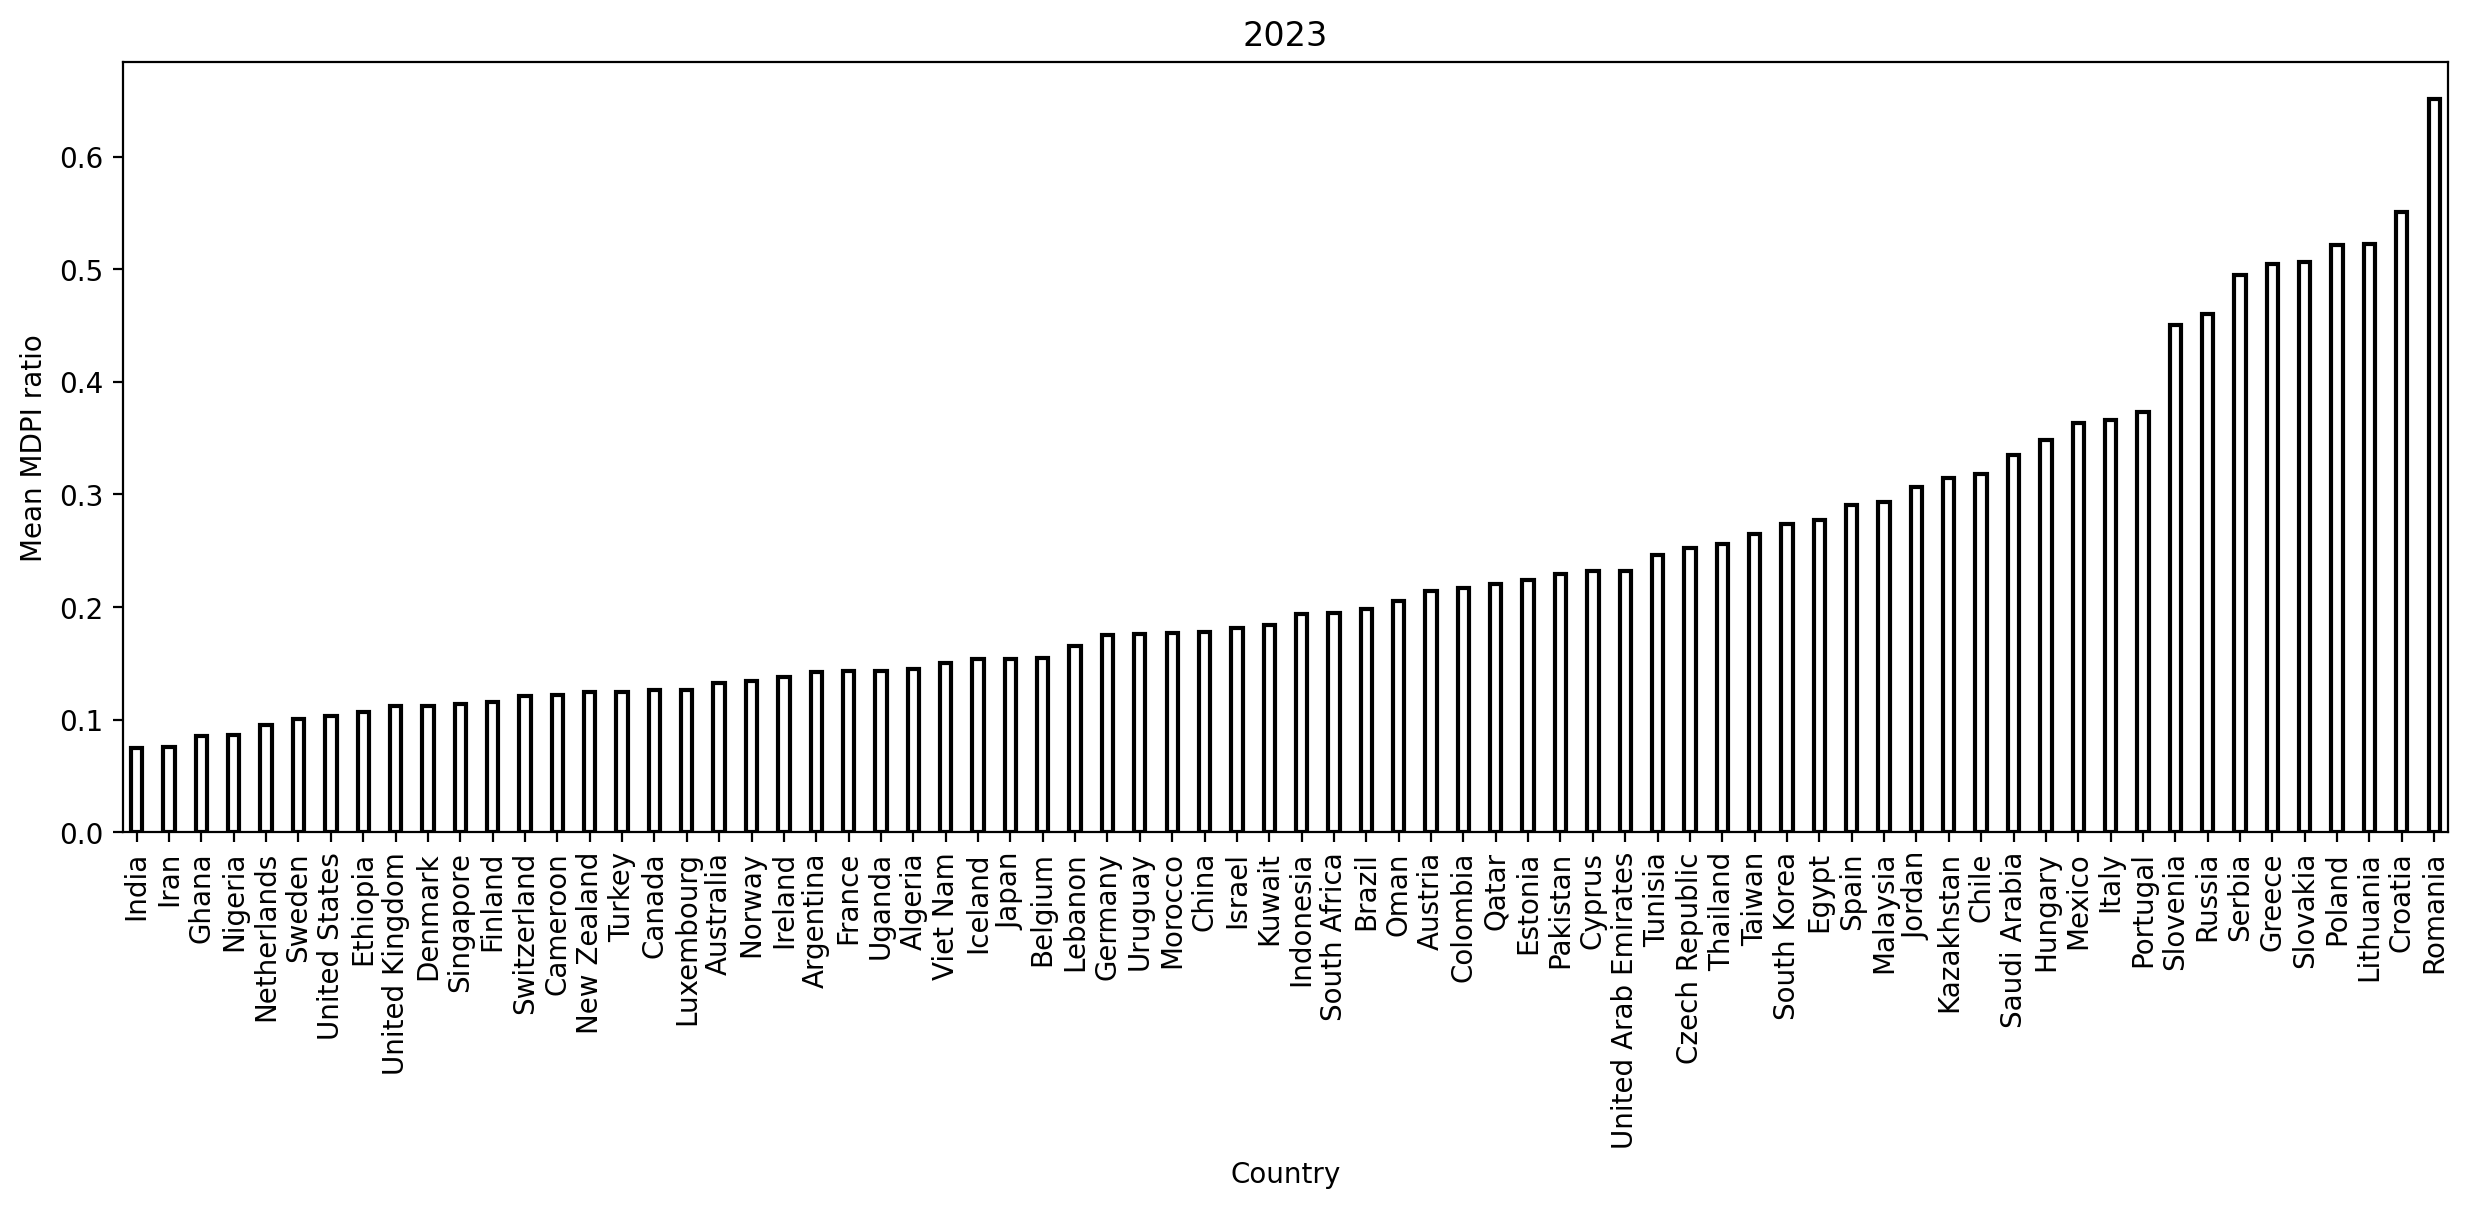

In [11]:
# plot country_mean for all countries for 2019, bar plot
country_mean.iloc[4].sort_values().plot(kind='bar', figsize=(15,5), title='2023', xlabel='Country', ylabel='Mean MDPI ratio', color='white', edgecolor='black',
width=0.35, linewidth=1.5)


In [18]:
EU = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France','Germany', 'Greece', 'Hungary', 'Ireland', 
      'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']
# which EU are in country_mean countries
EU = [c for c in EU if c in country_mean.columns]

In [22]:
# compute mean of country_mean for EU countries
country_mean.loc[:,EU].mean(axis=1)


year
2019    0.159408
2020    0.238294
2021    0.306617
2022    0.320611
2023    0.298602
dtype: float64

In [23]:
# compute mean of country_mean for non-EU countries
country_mean.loc[:,[c for c in country_mean.columns if c not in EU]].mean(axis=1)

year
2019    0.101610
2020    0.132927
2021    0.174260
2022    0.212725
2023    0.197609
dtype: float64

In [28]:
EU_OLD = ['Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain', 'Sweden']
EU_NEW = ['Croatia', 'Cyprus', 'Czech Republic', 'Estonia', 'Hungary', 'Lithuania', 'Poland', 'Romania', 'Slovakia', 'Slovenia']

In [32]:
# compute mean of country_mean for EU_OLD countries
mean_EU_OLD = country_mean.loc[:,EU_OLD].mean(axis=1)

In [33]:
# compute mean of country_mean for EU_NEW countries
mean_EU_NEW = country_mean.loc[:,EU_NEW].mean(axis=1)

(0.09, 0.51)

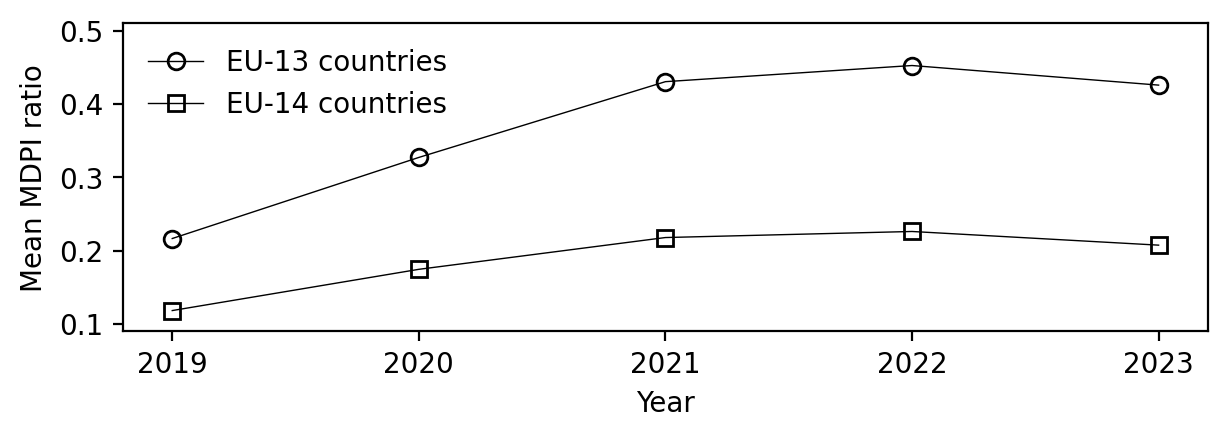

In [54]:
# plot mean_EU_OLD and mean_EU_NEW
plt.figure(figsize=(7, 2))
plt.plot(mean_EU_NEW,marker='.',color="black",ms=12, ls='-', mfc='none',lw=0.5, label="EU-13 countries")
plt.plot(mean_EU_OLD,marker='s',color="black",ms=6, ls='-', mfc='none',lw=0.5, label="EU-14 countries")
plt.xlabel('Year')
plt.ylabel('Mean MDPI ratio')
# plot legend without frame, place it in the upper left corner
plt.legend(frameon=False, loc='upper left')
plt.ylim(0.09,0.51)



In [30]:
# compute sd of country_mean for EU_OLD countries
country_mean.loc[:,EU_OLD].std(axis=1)

year
2019    0.047451
2020    0.074237
2021    0.095307
2022    0.110615
2023    0.126814
dtype: float64

In [31]:
# compute sd of country_mean for EU_NEW countries
country_mean.loc[:,EU_NEW].std(axis=1)

year
2019    0.065406
2020    0.111131
2021    0.140061
2022    0.140113
2023    0.151457
dtype: float64

In [30]:
# select first row of country_mean
country_mean.iloc[0].values

array([0.02380952, 0.05456243, 0.07626835, 0.13477213, 0.08839447,
       0.0661263 , 0.0616622 , 0.07423891, 0.14595268, 0.11690019,
       0.11271241, 0.19389089, 0.12487336, 0.19246088, 0.0845389 ,
       0.0945041 , 0.15062921, 0.064124  , 0.10286392, 0.0663461 ,
       0.10033228, 0.08567666, 0.19711289, 0.14494393, 0.11131059,
       0.02732697, 0.10096958, 0.03343796, 0.09152402, 0.07437219,
       0.18252578, 0.08771781, 0.12555066, 0.14696486, 0.10479042,
       0.06049149, 0.2603577 , 0.07598039, 0.16880016, 0.15300989,
       0.06166422, 0.07505086, 0.08188343, 0.04713333, 0.08454927,
       0.06553398, 0.16419462, 0.27651476, 0.16362694, 0.20562728,
       0.30397975, 0.13538427, 0.13623842, 0.14714347, 0.08207856,
       0.296074  , 0.22342687, 0.07976867, 0.20647663, 0.1987606 ,
       0.09681237, 0.0765291 , 0.22403629, 0.11878329, 0.07504134,
       0.03811332, 0.09917355, 0.14430542, 0.06525264, 0.05615016,
       0.10126582, 0.20966809])

<Axes: ylabel='Density'>

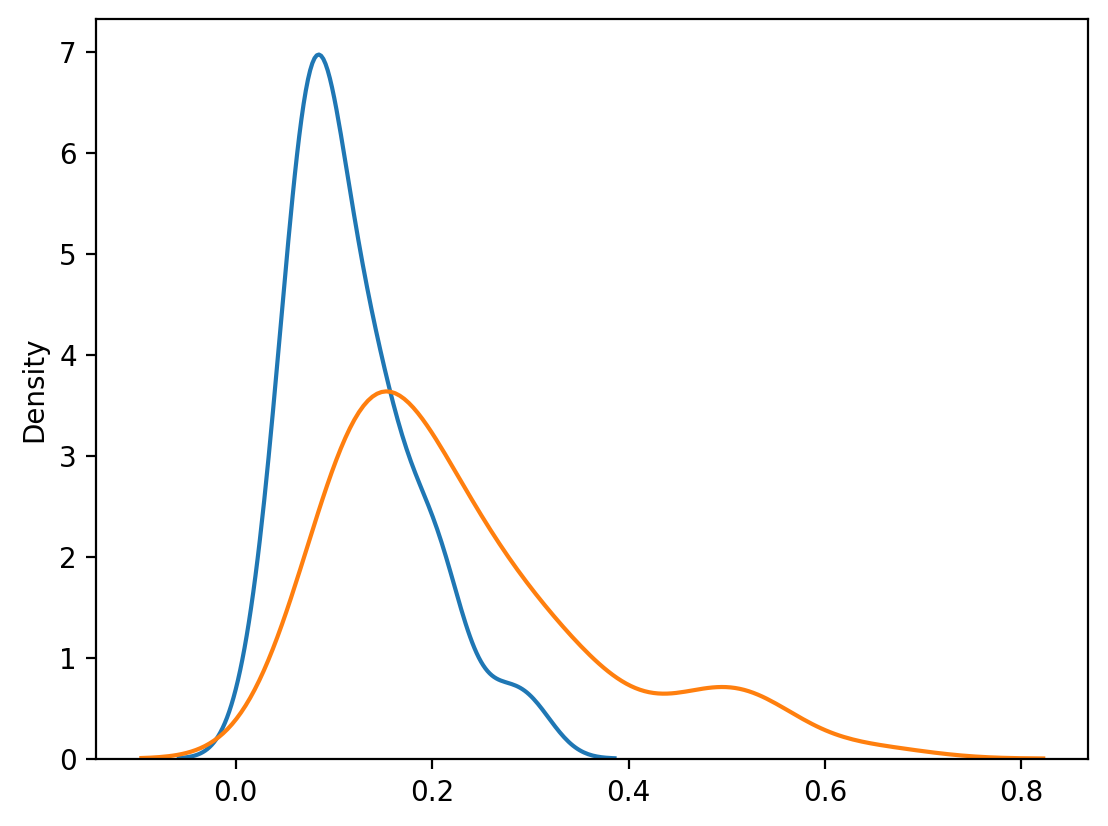

In [31]:
sns.kdeplot(country_mean.iloc[0].values, label='2019')
#sns.kdeplot(country_mean.iloc[1].values, label='2020')
#sns.kdeplot(country_mean.iloc[2].values, label='2021')
#sns.kdeplot(country_mean.iloc[3].values, label='2022')
sns.kdeplot(country_mean.iloc[4].values, label='2023')

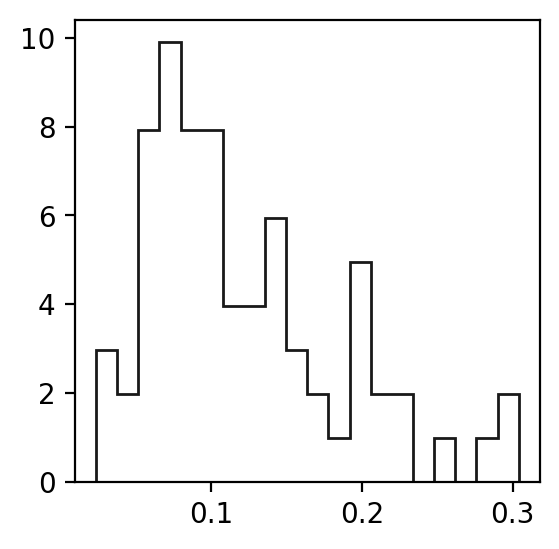

In [32]:
plt.figure(figsize=(3, 3))
plt.hist(country_mean.iloc[0].values, bins=20, density=True, alpha=0.9, color='black',histtype='step');

In [63]:
# Create a Gaussian Mixture model
gmm = GaussianMixture(n_components=2, random_state=0)

dt = country_mean.iloc[3].values.reshape(-1, 1)
dt = data2022['f_mdpi'].values.reshape(-1, 1)

# Fit the model
gmm.fit(dt)

# Parameters
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())

# Print estimated parameters
print("Weights:", weights)
print("Means:", means)
print("Standard Deviations:", stds)

# Plotting
x = np.linspace(-1, 1, 1000)
logprob = gmm.score_samples(x.reshape(-1, 1))
responsibilities = gmm.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]


Weights: [0.63834581 0.36165419]
Means: [0.13416033 0.33037041]
Standard Deviations: [0.05216914 0.13300692]


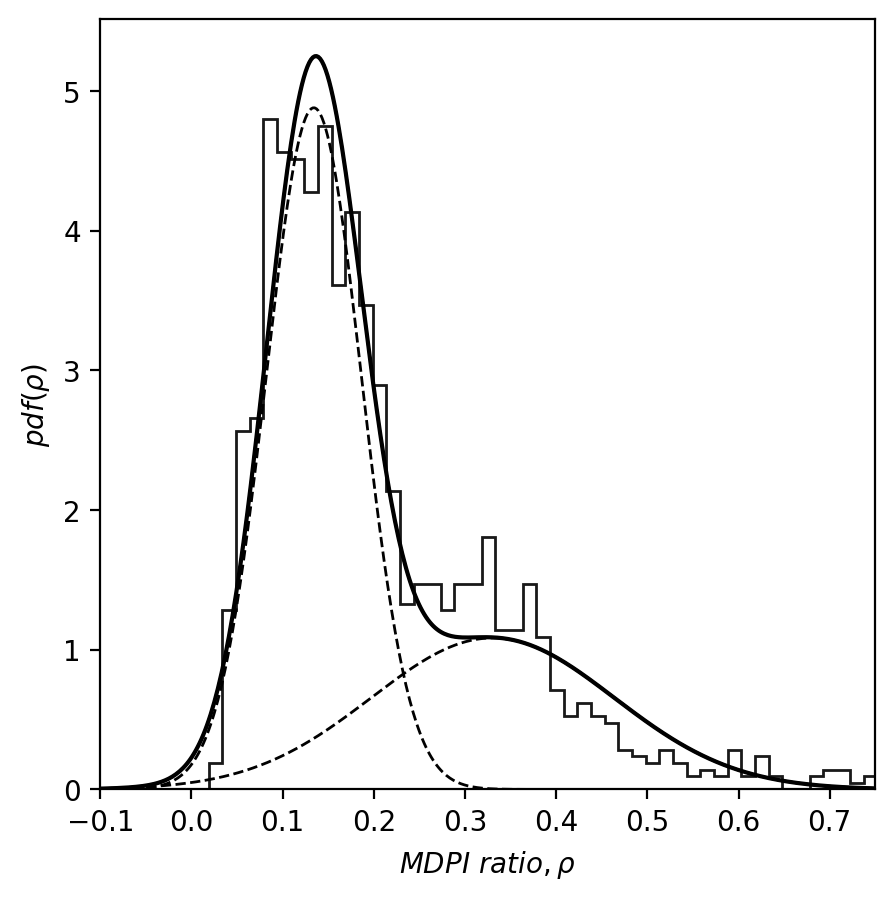

In [64]:
plt.figure(figsize=(5, 5))
plt.hist(dt, bins=50, density=True, alpha=0.9, color='black',histtype='step')
plt.plot(x, pdf, '-k', color='black', lw=1.0)
plt.plot(x, pdf_individual, '--', color='black', lw=1.0)
plt.plot(x, pdf, '-k')
#plt.title('Gaussian Mixture Model')
plt.xlabel(r'$MDPI\,\, ratio, \rho$')
plt.ylabel(r'$pdf(\rho)$')
plt.xlim(-.1, .75)
# log y scale
#plt.yscale('log')
#plt.ylim(1e-2, 20)
# plot size
plt.show()

In [39]:
# Fit a Gaussian Mixture Model with 2 components
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(dt.reshape(-1, 1))

# Predict the posterior probabilities
posterior_probs = gmm.predict_proba(dt.reshape(-1, 1))


# Assign each indicator to the component with the highest posterior probability
clusters = np.argmax(posterior_probs, axis=1)


# Separate the original indicators into two groups based on the assigned clusters
group1 = dt[clusters == 0]
group2 = dt[clusters == 1]

In [40]:
#country_mean.iloc[0].index[clusters == 0]
#c1 = data2022['country'][clusters == 1].unique()
#c2 = data2022['country'][clusters == 0].unique()
c1 = country_mean.iloc[4].index[clusters == 1]
c2 = country_mean.iloc[4].index[clusters == 0]

In [44]:
# which c1 are in countries
[c for c in c2 if c in countries]

['Austria',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 'Estonia',
 'Germany',
 'Greece',
 'Hungary',
 'Italy',
 'Lithuania',
 'Poland',
 'Portugal',
 'Romania',
 'Slovakia',
 'Slovenia',
 'Spain']

In [43]:
country_mean.iloc[1].index[clusters == 0]

Index(['Austria', 'Chile', 'Colombia', 'Croatia', 'Cyprus', 'Czech Republic',
       'Egypt', 'Estonia', 'Germany', 'Greece', 'Hungary', 'Indonesia',
       'Israel', 'Italy', 'Jordan', 'Kazakhstan', 'Kuwait', 'Lithuania',
       'Malaysia', 'Mexico', 'Oman', 'Pakistan', 'Poland', 'Portugal', 'Qatar',
       'Romania', 'Russia', 'Saudi Arabia', 'Serbia', 'Slovakia', 'Slovenia',
       'South Africa', 'South Korea', 'Spain', 'Taiwan', 'Thailand', 'Tunisia',
       'United Arab Emirates'],
      dtype='object', name='country')

In [45]:
df = pd.read_excel('../CWTS Leiden Ranking Open Edition 2023 - Results.xlsx', sheet_name='Results')
df['Period'] = df['Period'].str.replace('\u2013', '\u002d')

In [46]:
# from df select rows with 'All sciences' in 'Field', '1' in 'Frac_counting', '2018-2021' in 'Period'
df['Period'] = df['Period'].str.replace('\u2013', '\u002d')
#df_sel = df[(df['Field'] == 'All sciences') & (df['Frac_counting'] == '1') & (df['Period'] == '2018-2021')]
df_sel = df[(df['Field'] == 'All sciences')]
df_sel = df_sel[(df_sel['Frac_counting'] == 1)]
df_sel = df_sel[(df_sel['Period'] == '2018-2021')]



In [164]:
# combine data and df_sel on 'ROR_ID' column
data = data2023.merge(df_sel, left_on='ror id', right_on='ROR ID', how='left')


In [165]:
# order data by 'impact_P'  
data = data.sort_values(by='impact_P', ascending=False)

In [166]:
# add rank column to data
data['rank'] = range(1, len(data)+1)

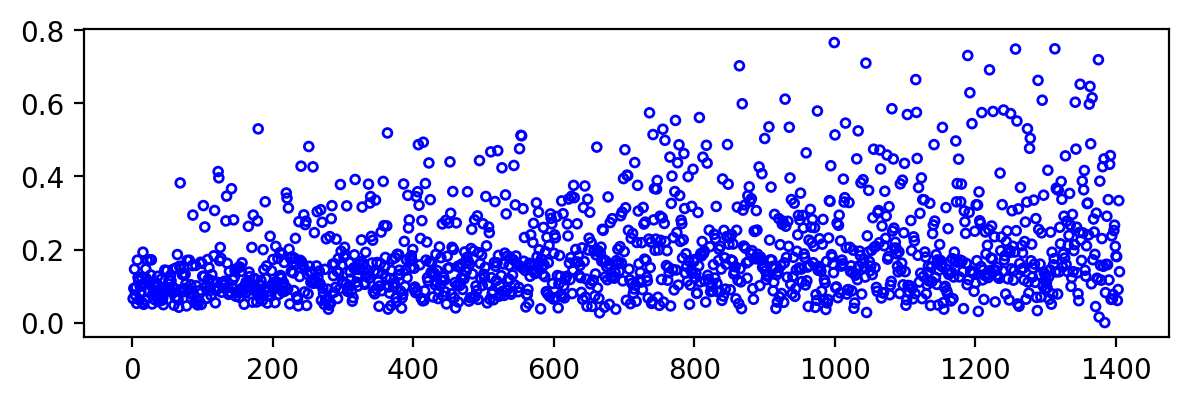

In [167]:
fig, ax = plt.subplots()
yy = data['f_mdpi']
xx = data['rank']
ax.scatter(xx, yy, marker='o', s=10, facecolors='none', edgecolors='b')

plt.gcf().set_size_inches(7, 2)
#ax.set_xlim(0.65, 1.01)
#ax.set_ylim(0.3, 1.1)

In [51]:
x = np.array(data['rank'].values)
y = np.array(data['f_mdpi'].values)

# find minimum x value greater than 0


# Define bins for a12 data
nbins = 50
bins = np.arange(0, np.max(x), nbins)  # 0-10, 10-20, ..., 90-100
# make log bins
#bins = np.logspace(0, np.log10(np.max(x)), nbins)


# Digitize the a12 data into bins
x_binned = np.digitize(x, bins)

# Calculate the mean of c10 in each bin
y_means = [y[x_binned == i].mean() for i in range(1, len(bins))]

# Mid-point of bins for plotting purposes
bin_midpoints = (bins[:-1] + bins[1:]) / 2

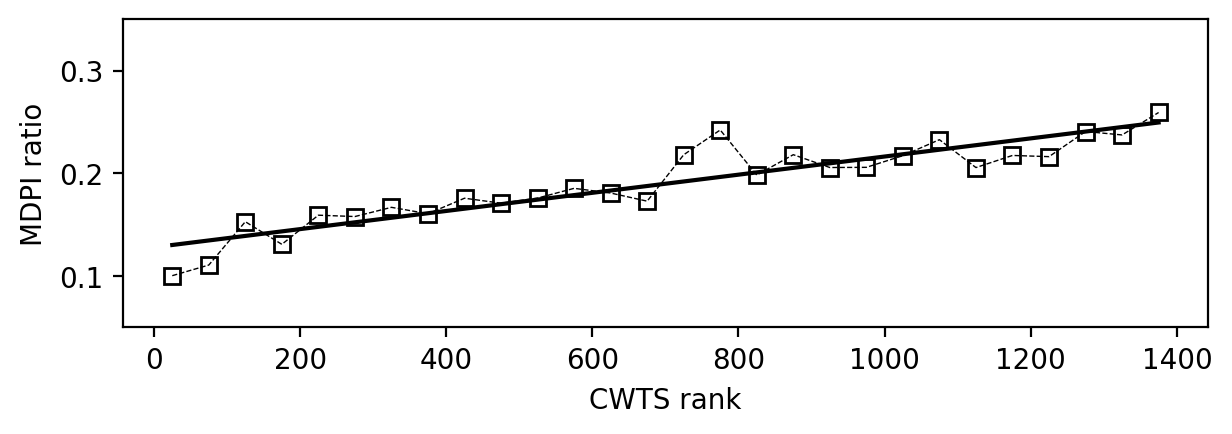

In [52]:
# Create the plot
plt.figure(figsize=(7, 2))
#plt.plot(x, y, alpha=0.2, label="Original Data", marker='.', ms=5, ls='', color='gray', mfc='none')  # Original data
plt.plot(bin_midpoints, y_means, marker='s',color="black", label="Binned Means", ms=6, ls='--', mfc='none',lw=0.5)  # Binned data
plt.xlabel('CWTS rank')
plt.ylabel('MDPI ratio')
# add linear fit line
plt.plot(np.unique(bin_midpoints), np.poly1d(np.polyfit(bin_midpoints, y_means, 1))(np.unique(bin_midpoints)), color='black', lw=1.5)
#plt.legend()
#plt.grid(True)
#plt.xlim(0, 1000)
plt.ylim(0.05, .35)
# log scale
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

In [5]:
ROR_API_ENDPOINT = "https://api.ror.org/organizations"
input_id = 'University of Maribor'
search_term = '"' + input_id + '"'
params = {'query': search_term}
response = requests.get(ROR_API_ENDPOINT + '?' + urllib.parse.urlencode(params)).json()

In [6]:
if response['number_of_results'] == 0:
    ror_id = ''
elif response['number_of_results'] == 1:
    ror_id = response['items'][0]['id']
else:
    ror_id = ''
    for items in response:
        ror_id = ror_id + ", " + response['items'][0]['id']
print("Found match: " + ror_id)

Found match: https://ror.org/01d5jce07


In [9]:
# read from coara-list.xlsx sheet2 to coara_list
coara_list = pd.read_excel('coara-list.xlsx', sheet_name='Sheet2', header=None) 

In [15]:
count_coara_uni_ror = 0
coara_list_ror = []
for uni in coara_list[0]:
    input_id = uni
    search_term = '"' + input_id + '"'
    params = {'query': search_term}
    response = requests.get(ROR_API_ENDPOINT + '?' + urllib.parse.urlencode(params)).json()
    if response['number_of_results'] == 0:
        ror_id = ''
    elif response['number_of_results'] >= 1:
        ror_id = response['items'][0]['id']
    #else:
    #    ror_id = ''
    #    for items in response:
    #        ror_id = ror_id + ", " + response['items'][0]['id']
    #print("Found match: " + ror_id)
    if ror_id != '':
        count_coara_uni_ror += 1
        coara_list_ror.append(ror_id)
    

In [16]:
len(coara_list_ror)

302

In [18]:
# get string after https://ror.org/ in coara_list_ror
coara_list_ror_ids = [i.split('https://ror.org/')[1] for i in coara_list_ror]

In [19]:
coara_list_ror_ids[:5]  

['00w7mf142', '039a2re55', '01faaaf77', '03ef4a036', '02n0bts35']

In [54]:
data['ror id'].isin(coara_list_ror_ids).sum()

168

In [55]:
# compute mean of mdpi ratios for universities in coara_list_ror_ids
data[data['ror id'].isin(coara_list_ror_ids)]['f_mdpi'].mean()

0.250872525876438

In [56]:
# compute mean of mdpi ratios for universities not in coara_list_ror_ids
data[~data['ror id'].isin(coara_list_ror_ids)]['f_mdpi'].mean()

0.18164503453285566

In [57]:
# compute mean of mdpi ratios for universities
data['f_mdpi'].mean()

0.18992277015258652

In [58]:
# get country codes for universities in coara_list_ror_ids
data[data['ror id'].isin(coara_list_ror_ids)]['country'].unique()

array(['Belgium', 'Netherlands', 'Italy', 'Switzerland', 'Sweden',
       'Finland', 'Portugal', 'Germany', 'France', 'Spain', 'Denmark',
       'Czech Republic', 'Ireland', 'United Kingdom', 'Poland',
       'Slovenia', 'Norway', 'Hungary', 'Lithuania', 'Slovakia',
       'Austria', 'Luxembourg', 'Iceland', 'Romania', 'Cyprus'],
      dtype=object)

In [66]:
# Create a Gaussian Mixture model
gmm = GaussianMixture(n_components=2, random_state=0)

#dt = country_mean.iloc[3].values.reshape(-1, 1)
#dt = data2022['f_mdpi'].values.reshape(-1, 1)
# get mdpi ratios for universities in coara_list_ror_ids
dt = data[data['ror id'].isin(coara_list_ror_ids)]['f_mdpi'].values.reshape(-1, 1)

# Fit the model
gmm.fit(dt)

# Parameters
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())

# Print estimated parameters
print("Weights:", weights)
print("Means:", means)
print("Standard Deviations:", stds)

# Plotting
x = np.linspace(-1, 1, 1000)
logprob = gmm.score_samples(x.reshape(-1, 1))
responsibilities = gmm.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]


Weights: [0.53582687 0.46417313]
Means: [0.3550253  0.13064183]
Standard Deviations: [0.12546576 0.03437422]


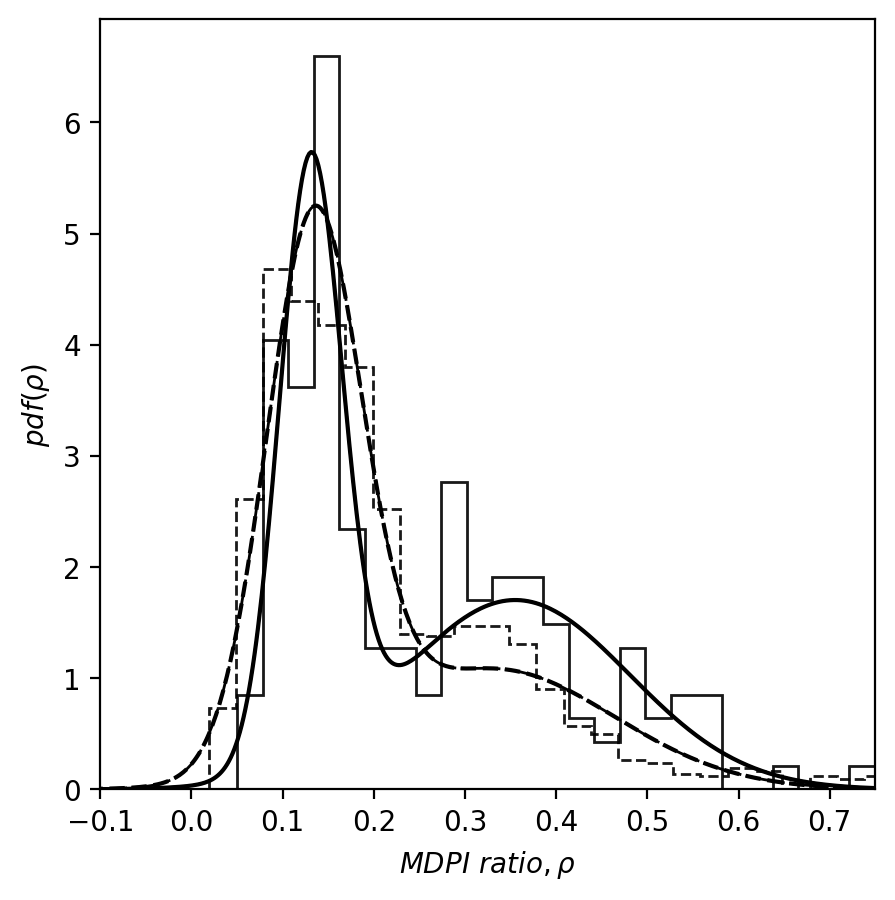

In [80]:
plt.figure(figsize=(5, 5))
gmm = GaussianMixture(n_components=2, random_state=0)

#dt = country_mean.iloc[3].values.reshape(-1, 1)
#dt = data2022['f_mdpi'].values.reshape(-1, 1)
# get mdpi ratios for universities in coara_list_ror_ids
dt = data[data['ror id'].isin(coara_list_ror_ids)]['f_mdpi'].values.reshape(-1, 1)

# Fit the model
gmm.fit(dt)

# Parameters
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())


# Plotting
x = np.linspace(-1, 1, 1000)
logprob = gmm.score_samples(x.reshape(-1, 1))
responsibilities = gmm.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.hist(dt, bins=25, density=True, alpha=0.9, color='black',histtype='step')
plt.plot(x, pdf, '-k', color='black', lw=1.0)
#plt.plot(x, pdf_individual, '--', color='black', lw=1.0)
plt.plot(x, pdf, '-k')

gmm = GaussianMixture(n_components=2, random_state=0)

#dt = country_mean.iloc[3].values.reshape(-1, 1)
dt = data2022['f_mdpi'].values.reshape(-1, 1)
# get mdpi ratios for universities in coara_list_ror_ids
#dt = data[data['ror id'].isin(coara_list_ror_ids)]['f_mdpi'].values.reshape(-1, 1)

# Fit the model
gmm.fit(dt)

# Parameters
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_.flatten())

x = np.linspace(-1, 1, 1000)
logprob = gmm.score_samples(x.reshape(-1, 1))
responsibilities = gmm.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.hist(dt, bins=25, density=True, alpha=0.9, color='black',histtype='step', linestyle='--')
plt.plot(x, pdf, '-k', color='black', lw=1.0, ls='dashed')
#plt.plot(x, pdf_individual, '--', color='black', lw=1.0)
plt.plot(x, pdf, '-k', linestyle='--')



#plt.title('Gaussian Mixture Model')
plt.xlabel(r'$MDPI\,\, ratio, \rho$')
plt.ylabel(r'$pdf(\rho)$')
plt.xlim(-.1, .75)
# log y scale
#plt.yscale('log')
#plt.ylim(1e-2, 20)
# plot size
plt.show()

In [83]:
# read csv from './THEUR/2023-ranking.csv' to theur
theur = pd.read_csv('./THEUR/2023_rankings.csv')

In [86]:
# find rows where 'location' is 'Slovenia'
theur[theur['location'] == 'Slovenia']

,rank_order,rank,name,scores_overall,scores_overall_rank,scores_teaching,scores_teaching_rank,scores_research,scores_research_rank,scores_citations,...,scores_international_outlook_rank,location,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students,stats_female_male_ratio,aliases,subjects_offered,closed,unaccredited
893,8940,801–1000,University of Ljubljana,29.8–33.9,8940,21.9,961,19.5,764,47.1,...,721,Slovenia,"37,615",13.1,8%,60 : 40,University of Ljubljana,"History, Philosophy & Theology,Electrical & El...",False,False
1347,13480,1201–1500,University of Maribor,18.4–24.3,13480,17.2,1463,17.4,871,28.3,...,849,Slovenia,"12,403",14.3,10%,53 : 47,University of Maribor,"Law,History, Philosophy & Theology,Mechanical ...",False,False
1398,13990,1201–1500,University of Primorska,18.4–24.3,13990,15.8,1616,14.2,1094,16.3,...,367,Slovenia,"6,089",16.6,15%,76 : 24,University of Primorska,"Mathematics & Statistics,Other Health,Geograph...",False,False
2158,1000346,Reporter,University of Nova Gorica,NaN,1000346,NaN,0,NaN,0,NaN,...,0,Slovenia,416,3.5,54%,48 : 52,University of Nova Gorica,"Chemical Engineering,Art, Performing Arts & De...",False,False


In [85]:
theur.columns

Index(['rank_order', 'rank', 'name', 'scores_overall', 'scores_overall_rank',
       'scores_teaching', 'scores_teaching_rank', 'scores_research',
       'scores_research_rank', 'scores_citations', 'scores_citations_rank',
       'scores_industry_income', 'scores_industry_income_rank',
       'scores_international_outlook', 'scores_international_outlook_rank',
       'location', 'stats_number_students', 'stats_student_staff_ratio',
       'stats_pc_intl_students', 'stats_female_male_ratio', 'aliases',
       'subjects_offered', 'closed', 'unaccredited'],
      dtype='object')

In [87]:
# extract 'name' from theur where 'scores_overall' is not NaN to theur_list
theur_list = theur[theur['scores_overall'].notnull()]['name']

In [88]:
len(theur_list)

1799

In [92]:
count_theur_uni_ror = 0
theur_list_ror = []
theur_uni = []
for uni in theur_list:
    input_id = uni
    search_term = '"' + input_id + '"'
    params = {'query': search_term}
    response = requests.get(ROR_API_ENDPOINT + '?' + urllib.parse.urlencode(params)).json()
    if response['number_of_results'] == 0:
        ror_id = ''
    elif response['number_of_results'] >= 1:
        ror_id = response['items'][0]['id']
    #else:
    #    ror_id = ''
    #    for items in response:
    #        ror_id = ror_id + ", " + response['items'][0]['id']
    #print("Found match: " + ror_id)
    if ror_id != '':
        count_theur_uni_ror += 1
        theur_list_ror.append(ror_id)
        theur_uni.append(uni)

In [93]:
theur_list_ror_ids = [i.split('https://ror.org/')[1] for i in theur_list_ror]

In [95]:
theur_uni[321], theur_list_ror_ids[321]

('Central South University', '00f1zfq44')

In [96]:
# extract rows from theur where 'name' is in theur_uni to theur_ror and add 'ror id' column with values from theur_list_ror_ids
theur_ror = theur[theur['name'].isin(theur_uni)]
theur_ror['ror id'] = theur_list_ror_ids

In [97]:
theur_ror

,rank_order,rank,name,scores_overall,scores_overall_rank,scores_teaching,scores_teaching_rank,scores_research,scores_research_rank,scores_citations,...,location,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students,stats_female_male_ratio,aliases,subjects_offered,closed,unaccredited,ror id
0,10,1,University of Oxford,96.4,10,92.3,5,99.7,1,99.0,...,United Kingdom,"20,965",10.6,42%,48 : 52,University of Oxford,"Accounting & Finance,General Engineering,Commu...",False,False,052gg0110
1,20,2,Harvard University,95.2,20,94.8,1,99.0,3,99.3,...,United States,"21,887",9.6,25%,50 : 50,Harvard University,"Mathematics & Statistics,Civil Engineering,Lan...",False,False,03vek6s52
2,30,=3,University of Cambridge,94.8,30,90.9,7,99.5,2,97.0,...,United Kingdom,"20,185",11.3,39%,47 : 53,University of Cambridge,"Business & Management,General Engineering,Art,...",False,False,013meh722
3,40,=3,Stanford University,94.8,40,94.2,2,96.7,7,99.8,...,United States,"16,164",7.1,24%,46 : 54,Stanford University,"Physics & Astronomy,Computer Science,Politics ...",False,False,00f54p054
4,50,5,Massachusetts Institute of Technology,94.2,50,90.7,8,93.6,11,99.8,...,United States,"11,415",8.2,33%,40 : 60,Massachusetts Institute of Technology,"Mathematics & Statistics,Languages, Literature...",False,False,042nb2s44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,17930,1501+,West University of Timişoara,10.4–18.3,17930,18.7,1258,13.4,1158,16.8,...,Romania,"14,527",24.6,6%,66 : 34,West University of Timişoara,"Accounting & Finance,Physics & Astronomy,Busin...",False,False,0583a0t97
1793,17940,1501+,Wrocław University of Science and Technology,10.4–18.3,17940,17.9,1369,16.0,960,14.9,...,Poland,"23,657",20.3,6%,35 : 65,Wrocław University of Science and Technology,"Architecture,Chemistry,Mathematics & Statistic...",False,False,008fyn775
1794,17950,1501+,Yamaguchi University,10.4–18.3,17950,21.3,1020,12.3,1264,13.9,...,Japan,"10,724",11.1,7%,38 : 62,Yamaguchi University,"Economics & Econometrics,Mechanical & Aerospac...",False,False,03cxys317
1795,17960,1501+,Yanshan University,10.4–18.3,17960,17.2,1465,10.9,1410,18.3,...,China,"38,649",13.2,1%,39 : 61,Yanshan University,"Chemical Engineering,Geology, Environmental, E...",False,False,02txfnf15


In [98]:
# save theur_ror to theur_ror.xlsx
# theur_ror.to_excel('theur2023_ror.xlsx', index=False)

In [99]:
# merge data and theur_ror on 'ror id' column
data_theur = data.merge(theur_ror, on='ror id', how='left')

In [100]:
data_theur

,uni,ror id,country,year,n_papers_all,paper_type,n_paper_type,n_publishers,n_mdpi,n_taylor_francis,...,scores_international_outlook_rank,location,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students,stats_female_male_ratio,aliases,subjects_offered,closed,unaccredited
0,Harvard University,03vek6s52,United States,2023,32121,journal-article,27130,385,863,402,...,214.0,United States,"21,887",9.6,25%,50 : 50,Harvard University,"Mathematics & Statistics,Civil Engineering,Lan...",False,False
1,Shanghai Jiao Tong University,0220qvk04,China,2023,27826,journal-article,20816,290,972,355,...,842.0,China,"37,478",11.5,8%,42 : 58,Shanghai Jiao Tong University SJTU,"Medicine & Dentistry,Veterinary Science,Politi...",False,False
2,Zhejiang University,00a2xv884,China,2023,27524,journal-article,20380,296,1605,421,...,573.0,China,"46,124",12.0,16%,NaN,Zhejiang University ZJU Zhejiang University Ch...,"Architecture,Other Health,Biological Sciences,...",False,False
3,University of Toronto,03dbr7087,Canada,2023,24294,journal-article,19151,472,652,603,...,115.0,Canada,"77,468",25.8,26%,56 : 44,University of Toronto,Politics & International Studies (incl Develop...,False,False
4,Sichuan University,011ashp19,China,2023,21300,journal-article,16823,280,838,257,...,993.0,China,"49,543",15.8,6%,NaN,Sichuan University,"Mathematics & Statistics,Biological Sciences,L...",False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1401,University of South Bohemia in České Budějovice,033n3pw66,Czech Republic,2023,887,journal-article,752,93,79,20,...,647.0,Czech Republic,"8,763",13.8,7%,69 : 31,University of South Bohemia in České Budějovice,"General Engineering,Agriculture & Forestry,Pol...",False,False
1402,College of William and Mary,03hsf0573,United States,2023,885,journal-article,659,97,17,50,...,1078.0,United States,"8,089",10.9,8%,56 : 44,William & Mary,"Psychology,Computer Science,Sport Science,Hist...",False,False
1403,Shandong University of Traditional Chinese Med...,0523y5c19,China,2023,1570,journal-article,1179,72,42,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1404,Central South University of Forestry and Techn...,02czw2k81,China,2023,1416,journal-article,1181,63,266,26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
# save data_theur to data_theur.xlsx
data_theur.to_excel('all_data_with_theur2023.xlsx', index=False)


In [124]:
data_theur['rank'] = range(1, len(data_theur)+1)

In [105]:
data_theur.columns.to_list()

['uni',
 'ror id',
 'country',
 'year',
 'n_papers_all',
 'paper_type',
 'n_paper_type',
 'n_publishers',
 'n_mdpi',
 'n_taylor_francis',
 'n_springer_nature',
 'n_wiley',
 'n_sage',
 'n_elsevier',
 'n_is_retracted',
 'n_is_oa',
 'n_is_oa_gold',
 'sum',
 'f_mdpi',
 'University',
 'ROR ID',
 'Country',
 'Field',
 'Period',
 'Frac_counting',
 'impact_P',
 'collab_P',
 'oa_P',
 'TCS',
 'TNCS',
 'P_top1',
 'P_top5',
 'P_top10',
 'P_top50',
 'P_collab',
 'P_int_collab',
 'P_industry_collab',
 'P_short_dist_collab',
 'P_long_dist_collab',
 'P_OA',
 'P_gold_OA',
 'P_hybrid_OA',
 'P_bronze_OA',
 'P_green_OA',
 'P_OA_unknown',
 'MCS',
 'MCS_lb',
 'MCS_ub',
 'MNCS',
 'MNCS_lb',
 'MNCS_ub',
 'PP_top1',
 'PP_top1_lb',
 'PP_top1_ub',
 'PP_top5',
 'PP_top5_lb',
 'PP_top5_ub',
 'PP_top10',
 'PP_top10_lb',
 'PP_top10_ub',
 'PP_top50',
 'PP_top50_lb',
 'PP_top50_ub',
 'PP_collab',
 'PP_collab_lb',
 'PP_collab_ub',
 'PP_int_collab',
 'PP_int_collab_lb',
 'PP_int_collab_ub',
 'PP_industry_collab',
 'PP_i

In [128]:
data_theur[['rank_order','uni','rank']][:10]

,rank_order,uni,rank
0,20.0,Harvard University,1
1,520.0,Shanghai Jiao Tong University,2
2,670.0,Zhejiang University,3
3,180.0,University of Toronto,4
4,1970.0,Sichuan University,5
5,230.0,University of Michigan,6
6,3590.0,Central South University,7
7,160.0,Tsinghua University,8
8,2930.0,Sun Yat-sen University,9
9,150.0,Johns Hopkins University,10


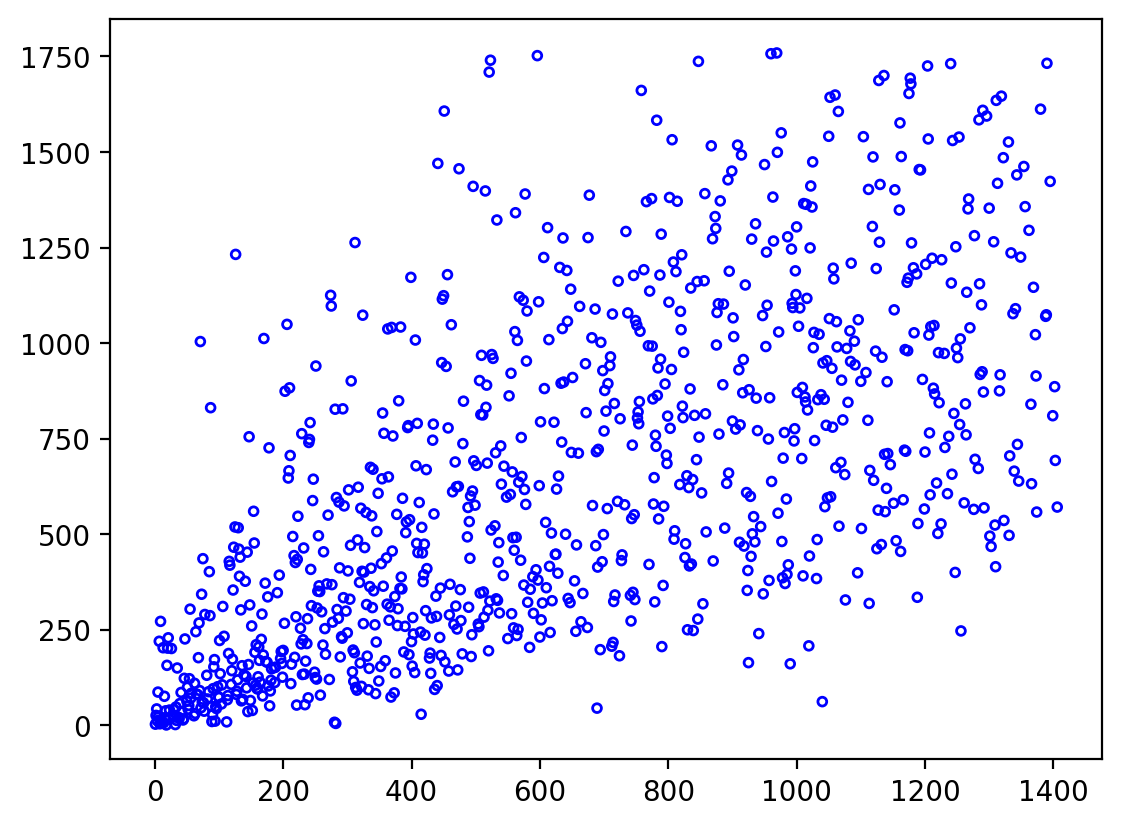

In [130]:
# plot scatter of 'scores_research' vs 'impact_P'
fig, ax = plt.subplots()
yy = data_theur['scores_research_rank']
xx = data_theur['rank']
ax.scatter(xx, yy, marker='o', s=10, facecolors='none', edgecolors='b')


In [140]:
x = np.array(data_theur['rank_order'].values)
y = np.array(data_theur['f_mdpi'].values)

# check for nan values in x and remove them and corresponding y values
nan_values = np.argwhere(np.isnan(x))
x = np.delete(x, nan_values)
y = np.delete(y, nan_values)


# find minimum x value greater than 0


# Define bins for a12 data
nbins = 500
bins = np.arange(0, np.max(x), nbins)  # 0-10, 10-20, ..., 90-100
# make log bins
#bins = np.logspace(0, np.log10(np.max(x)), nbins)


# Digitize the a12 data into bins
x_binned = np.digitize(x, bins)

# Calculate the mean of c10 in each bin
y_means = [y[x_binned == i].mean() for i in range(1, len(bins))]

# Mid-point of bins for plotting purposes
bin_midpoints = (bins[:-1] + bins[1:]) / 2

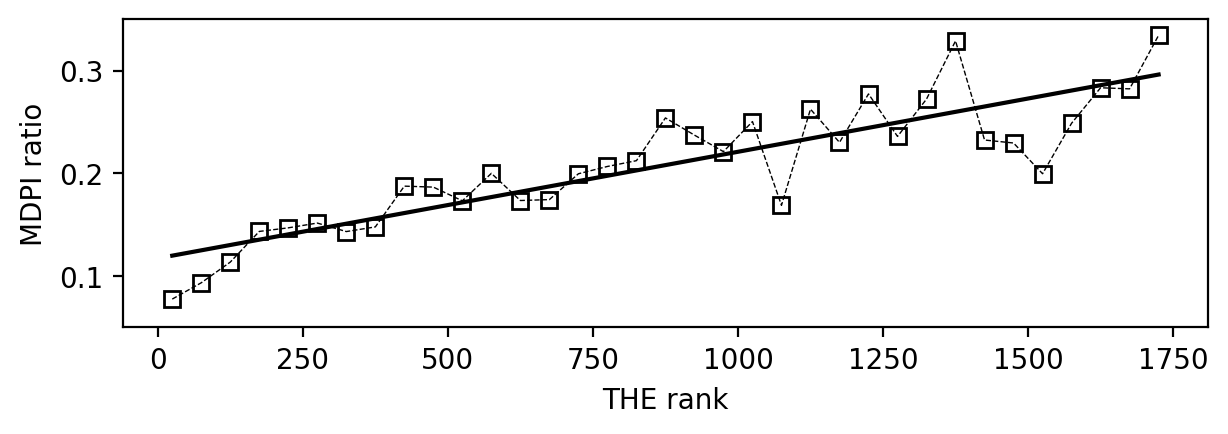

In [144]:
# Create the plot
plt.figure(figsize=(7, 2))
#plt.plot(x, y, alpha=0.2, label="Original Data", marker='.', ms=5, ls='', color='gray', mfc='none')  # Original data
plt.plot(bin_midpoints/10, y_means, marker='s',color="black", label="Binned Means", ms=6, ls='--', mfc='none',lw=0.5)  # Binned data
plt.xlabel('THE rank')
plt.ylabel('MDPI ratio')
# add linear fit line
plt.plot(np.unique(bin_midpoints/10), np.poly1d(np.polyfit(bin_midpoints/10, y_means, 1))(np.unique(bin_midpoints/10)), color='black', lw=1.5)
#plt.legend()
#plt.grid(True)
#plt.xlim(0, 1000)
plt.ylim(0.05, .35)
# log scale
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
plt.show()

In [225]:
countries = ['Denmark', 'Finland', 'Poland',
       'Greece', 'France', 'Romania', 'Germany', 'Italy', 'Czech Republic', 'Hungary', 'Spain', 'Sweden',
       'Slovakia', 'Netherlands', 'Ireland',
       'Cyprus', 'Belgium', 'Austria', 'Lithuania', 'Estonia', 'Portugal', 'Slovenia', 'Luxembourg', 'Croatia']

In [226]:
country_codes = ['DK', 'FI', 'PL', 'GR', 'FR', 'RO', 'DE', 'IT', 'CZ', 'HU', 'ES', 'SE', 'SK', 'NL', 'IE', 'CY', 'BE', 'AT', 'LT', 'EE', 'PT', 'SI', 'LU', 'HR']

In [106]:
df_indicators = pd.read_excel('../autonomy/indicators.xlsx')

In [107]:
df_indicators

,Country,PC,CC,CPI,Code,AA,SA,FA,OA,norm_Autonomy,...,8.4 Criminal system is impartial,8.5 Criminal system is free of corruption,8.6 Criminal system is free of improper government influence,8.7. Due process of the law and rights of the accused,Pop1K,MDPI 2022,GDP PPP,cname,cc_total,vdem_respect_const
0,Sweden,0.982,0.992,0.82,SE,0.670000,0.970000,0.560000,0.590000,0.687204,...,0.765167,0.917789,0.940802,0.902056,10612.086,0.065855,64578.396333,Sweden,1.641757,1.200146
1,Poland,0.863,0.868,0.54,PL,0.680000,0.870000,0.600000,0.710000,0.720379,...,0.583164,0.795988,0.421845,0.621791,41026.067,0.274344,43268.543713,Poland,0.916413,0.004591
2,Portugal,0.906,0.848,0.61,PT,0.540000,0.620000,0.700000,0.800000,0.625592,...,0.453390,0.774925,0.750849,0.626022,10247.605,0.179513,41451.614866,Portugal,1.872676,0.780879
3,France,0.962,0.950,0.71,FR,0.420000,0.440000,0.440000,0.570000,0.251185,...,0.542736,0.767170,0.674634,0.678514,64756.584,0.075287,55492.565547,France,0.377710,1.033441
4,Germany,0.987,0.981,0.78,DE,0.876667,0.613333,0.406667,0.676667,0.584518,...,0.716512,0.854604,0.898402,0.843665,83294.633,0.082190,63149.598690,Germany,1.676135,1.898447
5,Ireland,0.980,0.959,0.77,IE,0.890000,0.580000,0.630000,0.760000,0.720379,...,0.556873,0.820507,0.854765,0.813091,5056.935,0.066482,126905.198534,Ireland,1.316353,1.354688
6,Italy,0.818,0.861,0.56,IT,0.560000,0.490000,0.700000,0.650000,0.502370,...,0.619005,0.754287,0.828770,0.703630,58870.762,0.168539,51864.977735,Italy,1.559570,1.036302
7,Latvia,0.886,0.896,0.60,LV,0.550000,0.890000,0.900000,0.690000,0.800948,...,0.760578,0.688060,0.801526,0.723622,1830.211,0.216367,39956.190477,Latvia,1.855769,1.262392
8,Netherlands,0.978,0.978,0.79,NL,0.460000,0.920000,0.660000,0.830000,0.725118,...,0.648766,0.889942,0.864005,0.819552,17618.299,0.055738,69577.404580,Netherlands,0.906708,2.218978
9,Spain,0.967,0.941,0.60,ES,0.570000,0.500000,0.550000,0.550000,0.393365,...,0.631988,0.767306,0.611952,0.788896,47519.628,0.131809,45825.195633,Spain,1.872676,1.401909


In [108]:
# replace 'Czechia' with 'Czech Republic'
df_indicators['Country'] = df_indicators['Country'].replace('Czechia', 'Czech Republic')

In [109]:
# merge df_country with df_indicators on 'Country'
df_all = pd.merge(data, df_indicators, on='Country', how='left')

In [110]:
df_all

,uni,ror id,country,year,n_papers_all,paper_type,n_paper_type,n_publishers,n_mdpi,n_taylor_francis,...,8.4 Criminal system is impartial,8.5 Criminal system is free of corruption,8.6 Criminal system is free of improper government influence,8.7. Due process of the law and rights of the accused,Pop1K,MDPI 2022,GDP PPP,cname,cc_total,vdem_respect_const
0,Harvard University,03vek6s52,United States,2023,32121,journal-article,27130,385,863,402,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Shanghai Jiao Tong University,0220qvk04,China,2023,27826,journal-article,20816,290,972,355,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Zhejiang University,00a2xv884,China,2023,27524,journal-article,20380,296,1605,421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,University of Toronto,03dbr7087,Canada,2023,24294,journal-article,19151,472,652,603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sichuan University,011ashp19,China,2023,21300,journal-article,16823,280,838,257,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,University of South Bohemia in České Budějovice,033n3pw66,Czech Republic,2023,887,journal-article,752,93,79,20,...,0.661411,0.748824,0.821102,0.796422,10495.295,0.130429,49945.500104,Czechia,1.972334,0.418134
1401,College of William and Mary,03hsf0573,United States,2023,885,journal-article,659,97,17,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1402,Shandong University of Traditional Chinese Med...,0523y5c19,China,2023,1570,journal-article,1179,72,42,24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1403,Central South University of Forestry and Techn...,02czw2k81,China,2023,1416,journal-article,1181,63,266,26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [111]:
# select rows with 'Pop1K' > 0
df = df_all[df_all['Pop1K'] > 0]

In [112]:
# add columns 'code' to df that corresponds to country codes in countries, for other countries add 'Other'
df['code'] = df['Country'].apply(lambda x: country_codes[countries.index(x)] if x in countries else 'Other')


In [113]:
df['f_mdpi'].groupby(df['Code']).mean().sort_values()

Code
NL    0.094839
SE    0.100373
DK    0.112350
FI    0.115448
LU    0.125960
IE    0.138198
FR    0.142738
BE    0.154387
DE    0.174883
AT    0.213836
EE    0.224045
CY    0.231964
CZ    0.252498
ES    0.290640
IT    0.366133
PT    0.372896
SI    0.450051
GR    0.504763
SK    0.506659
PL    0.521116
LT    0.522789
HR    0.550481
RO    0.651453
Name: f_mdpi, dtype: float64

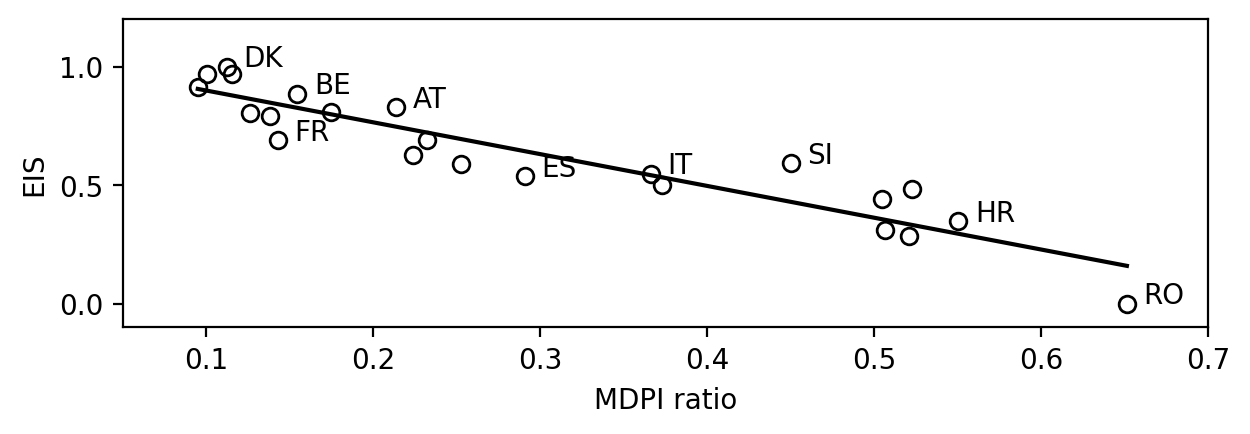

In [114]:
import numpy as np
from scipy.optimize import curve_fit
fig, ax = plt.subplots()
yy = df['norm_EIS'].groupby(df['Country']).mean()
#yy = df['MDPI 2023'].groupby(df['Country']).mean()

xx = df['f_mdpi'].groupby(df['Country']).mean()
#ax.scatter(xx, yy, marker='o', s=45, facecolors='none', edgecolors='black')
ax.plot(xx,yy,marker='.',color="black", label="Binned Means", ms=12, ls='', mfc='none',lw=0.5)

codes = df['code'].groupby(df['Country']).first()

#sns.regplot(x=xx, y=yy, scatter=False, ci=95, ax=ax)
plt.plot(np.unique(xx), np.poly1d(np.polyfit(xx, yy, 1))(np.unique(xx)), color='black', lw=1.5)
# annotate points with 'code'
for i, txt in enumerate(codes):
    if txt in ['SI','RO','HR','IT','ES','AT','BE','DK','FR']:
        ax.annotate(txt, (xx[i]+0.01, yy[i]))



ax.set_ylim(-.1, 1.2)
ax.set_xlim(0.05, .7)
ax.set_ylabel('EIS')
ax.set_xlabel('MDPI ratio')
plt.gcf().set_size_inches(7, 2)


In [115]:
#df.to_excel('all_indicators_university_level.xlsx')

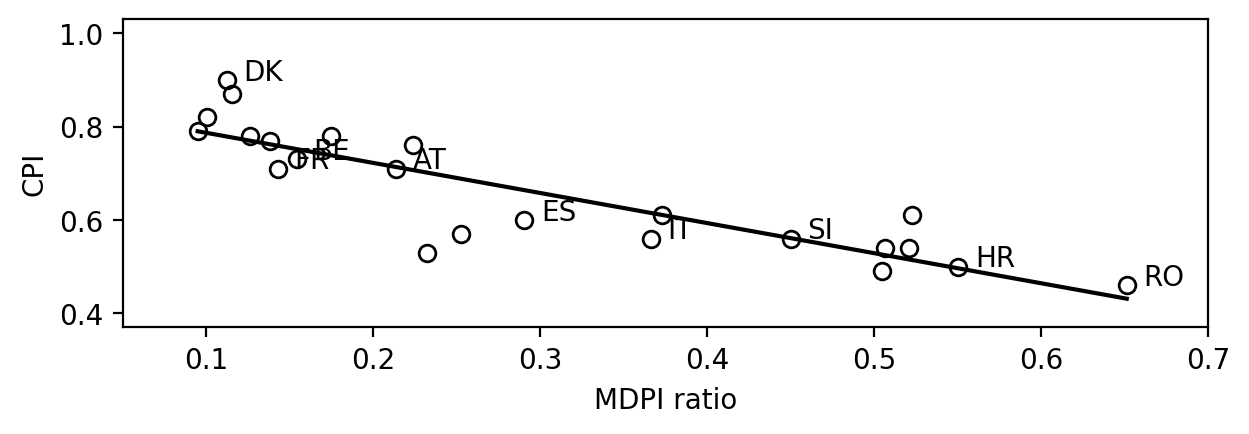

In [116]:
fig, ax = plt.subplots()
yy = df['norm_EIS'].groupby(df['Country']).mean()
#yy = df['MDPI 2023'].groupby(df['Country']).mean()
yy = df['CPI'].groupby(df['Country']).mean()


xx = df['f_mdpi'].groupby(df['Country']).mean()
#ax.scatter(xx, yy, marker='o', s=45, facecolors='none', edgecolors='black')
ax.plot(xx,yy,marker='.',color="black", label="Binned Means", ms=12, ls='', mfc='none',lw=0.5)

codes = df['code'].groupby(df['Country']).first()

#sns.regplot(x=xx, y=yy, scatter=False, ci=95, ax=ax)
plt.plot(np.unique(xx), np.poly1d(np.polyfit(xx, yy, 1))(np.unique(xx)), color='black', lw=1.5)
# annotate points with 'code'
for i, txt in enumerate(codes):
    if txt in ['SI','RO','HR','IT','ES','AT','BE','DK','FR']:
        ax.annotate(txt, (xx[i]+0.01, yy[i]))



ax.set_ylim(.37, 1.03)
ax.set_xlim(0.05, .7)
ax.set_ylabel('CPI')
ax.set_xlabel('MDPI ratio')
plt.gcf().set_size_inches(7, 2)

In [217]:
# show 'University of Ljubljana' and 'University of Maribor' rows in df
umul = df[df['University'].str.contains('Ljubljana|Maribor')][['University','impact_P','P_top10','P_top50','P_top5','P_top1','PP_top1','PP_top5','PP_top10','PP_top50']]


In [218]:
umul

,University,impact_P,P_top10,P_top50,P_top5,P_top1,PP_top1,PP_top5,PP_top10,PP_top50
356,University of Ljubljana,4910.429263,449.217045,2453.620120,223.271029,37.795978,0.007697,0.045469,0.091482,0.499675
999,University of Maribor,1611.939976,152.461861,800.270173,81.003834,15.530185,0.009634,0.050252,0.094583,0.496464


In [269]:
# compute ratio of imact_P between 'University of Ljubljana' and 'University of Maribor' add to new row 'ratio'
r = ['ratio',umul['impact_P'].iloc[0]/umul['impact_P'].iloc[1], umul['P_top10'].iloc[0]/umul['P_top10'].iloc[1], 
     umul['P_top50'].iloc[0]/umul['P_top50'].iloc[1], umul['P_top5'].iloc[0]/umul['P_top5'].iloc[1], umul['P_top1'].iloc[0]/umul['P_top1'].iloc[1],
     np.nan, np.nan, np.nan, np.nan]

r
# add r as row to umul, padding with NaN values 
umul = umul.append(pd.Series(r, index=umul.columns), ignore_index=True)


In [270]:
umul

,University,impact_P,P_top10,P_top50,P_top5,P_top1,PP_top1,PP_top5,PP_top10,PP_top50
0,University of Ljubljana,4910.429263,449.217045,2453.620120,223.271029,37.795978,0.007697,0.045469,0.091482,0.499675
1,University of Maribor,1611.939976,152.461861,800.270173,81.003834,15.530185,0.009634,0.050252,0.094583,0.496464
2,ratio,3.046285,2.946422,3.065990,2.756302,2.433711,NaN,NaN,NaN,NaN


In [191]:
# ration of 'University of Ljubljana' and 'University of Maribor' in df['impact_P']
df[df['University'].str.contains('Ljubljana')]['impact_P'].values/df[df['University'].str.contains('Maribor')]['impact_P'].values

array([3.04628543])

In [ ]:
####################